### Boosting

In this notebook, we'll test out boosting on the same Photometric Redshift data set that we used in the previous studio. 

We'll start with an adaptive boosting method (AdaBoost) and a Gradient Boosting method (GBM). Then we'll see how other gradient boosting methods, like HistGBM, compare in terms of performance and training speed. Along the way, we'll learn to use a Random Search for hyperparameter optimization. 

Copyright: Viviana Acquaviva (2023); see also other data credits below.

Modifications and additions by Julieta Gruszko (2025).

License: [BSD-3-clause](https://opensource.org/license/bsd-3-clause/)

We are using [this paper](https://arxiv.org/abs/1903.08174), for which the data are public and available [here](http://d-scholarship.pitt.edu/36064/), for inspiration.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 100)

font = {'size'   : 16}
matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
#matplotlib.rcParams.update({'figure.autolayout': True})
matplotlib.rcParams['figure.dpi'] = 300

In [ ]:
from sklearn import metrics
from sklearn.model_selection import cross_validate, KFold, cross_val_predict, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor, GradientBoostingRegressor
from sklearn import stat

Reference for comparison of weak learners as base estimators:

https://link.springer.com/chapter/10.1007/978-3-642-20042-7_32

### Reading in Data 

We can read in the photometric redshifts data set with the selection criteria applied in our last studio. I went ahead and saved it to the "Data" folder for you. 

In [4]:
sel_features = pd.read_csv('../Data/sel_features.csv', sep = '\t')

In [5]:
sel_target = pd.read_csv('../Data/sel_target.csv')

In [6]:
sel_features.shape

(6307, 6)

In [7]:
sel_target.values.ravel() #changes shape to 1d row-like array

array([1.0034, 0.9023, 0.4242, ..., 0.3703, 0.371 , 0.7333], shape=(6307,))

### We can try our usual benchmarking with AdaBoost, using default values.

In [8]:
model = AdaBoostRegressor()

In [9]:
ypred = cross_val_predict(model, sel_features,sel_target.values.ravel(), cv = KFold(n_splits=5, shuffle=True, random_state=10))

Text(0.5, 0, 'Target value')

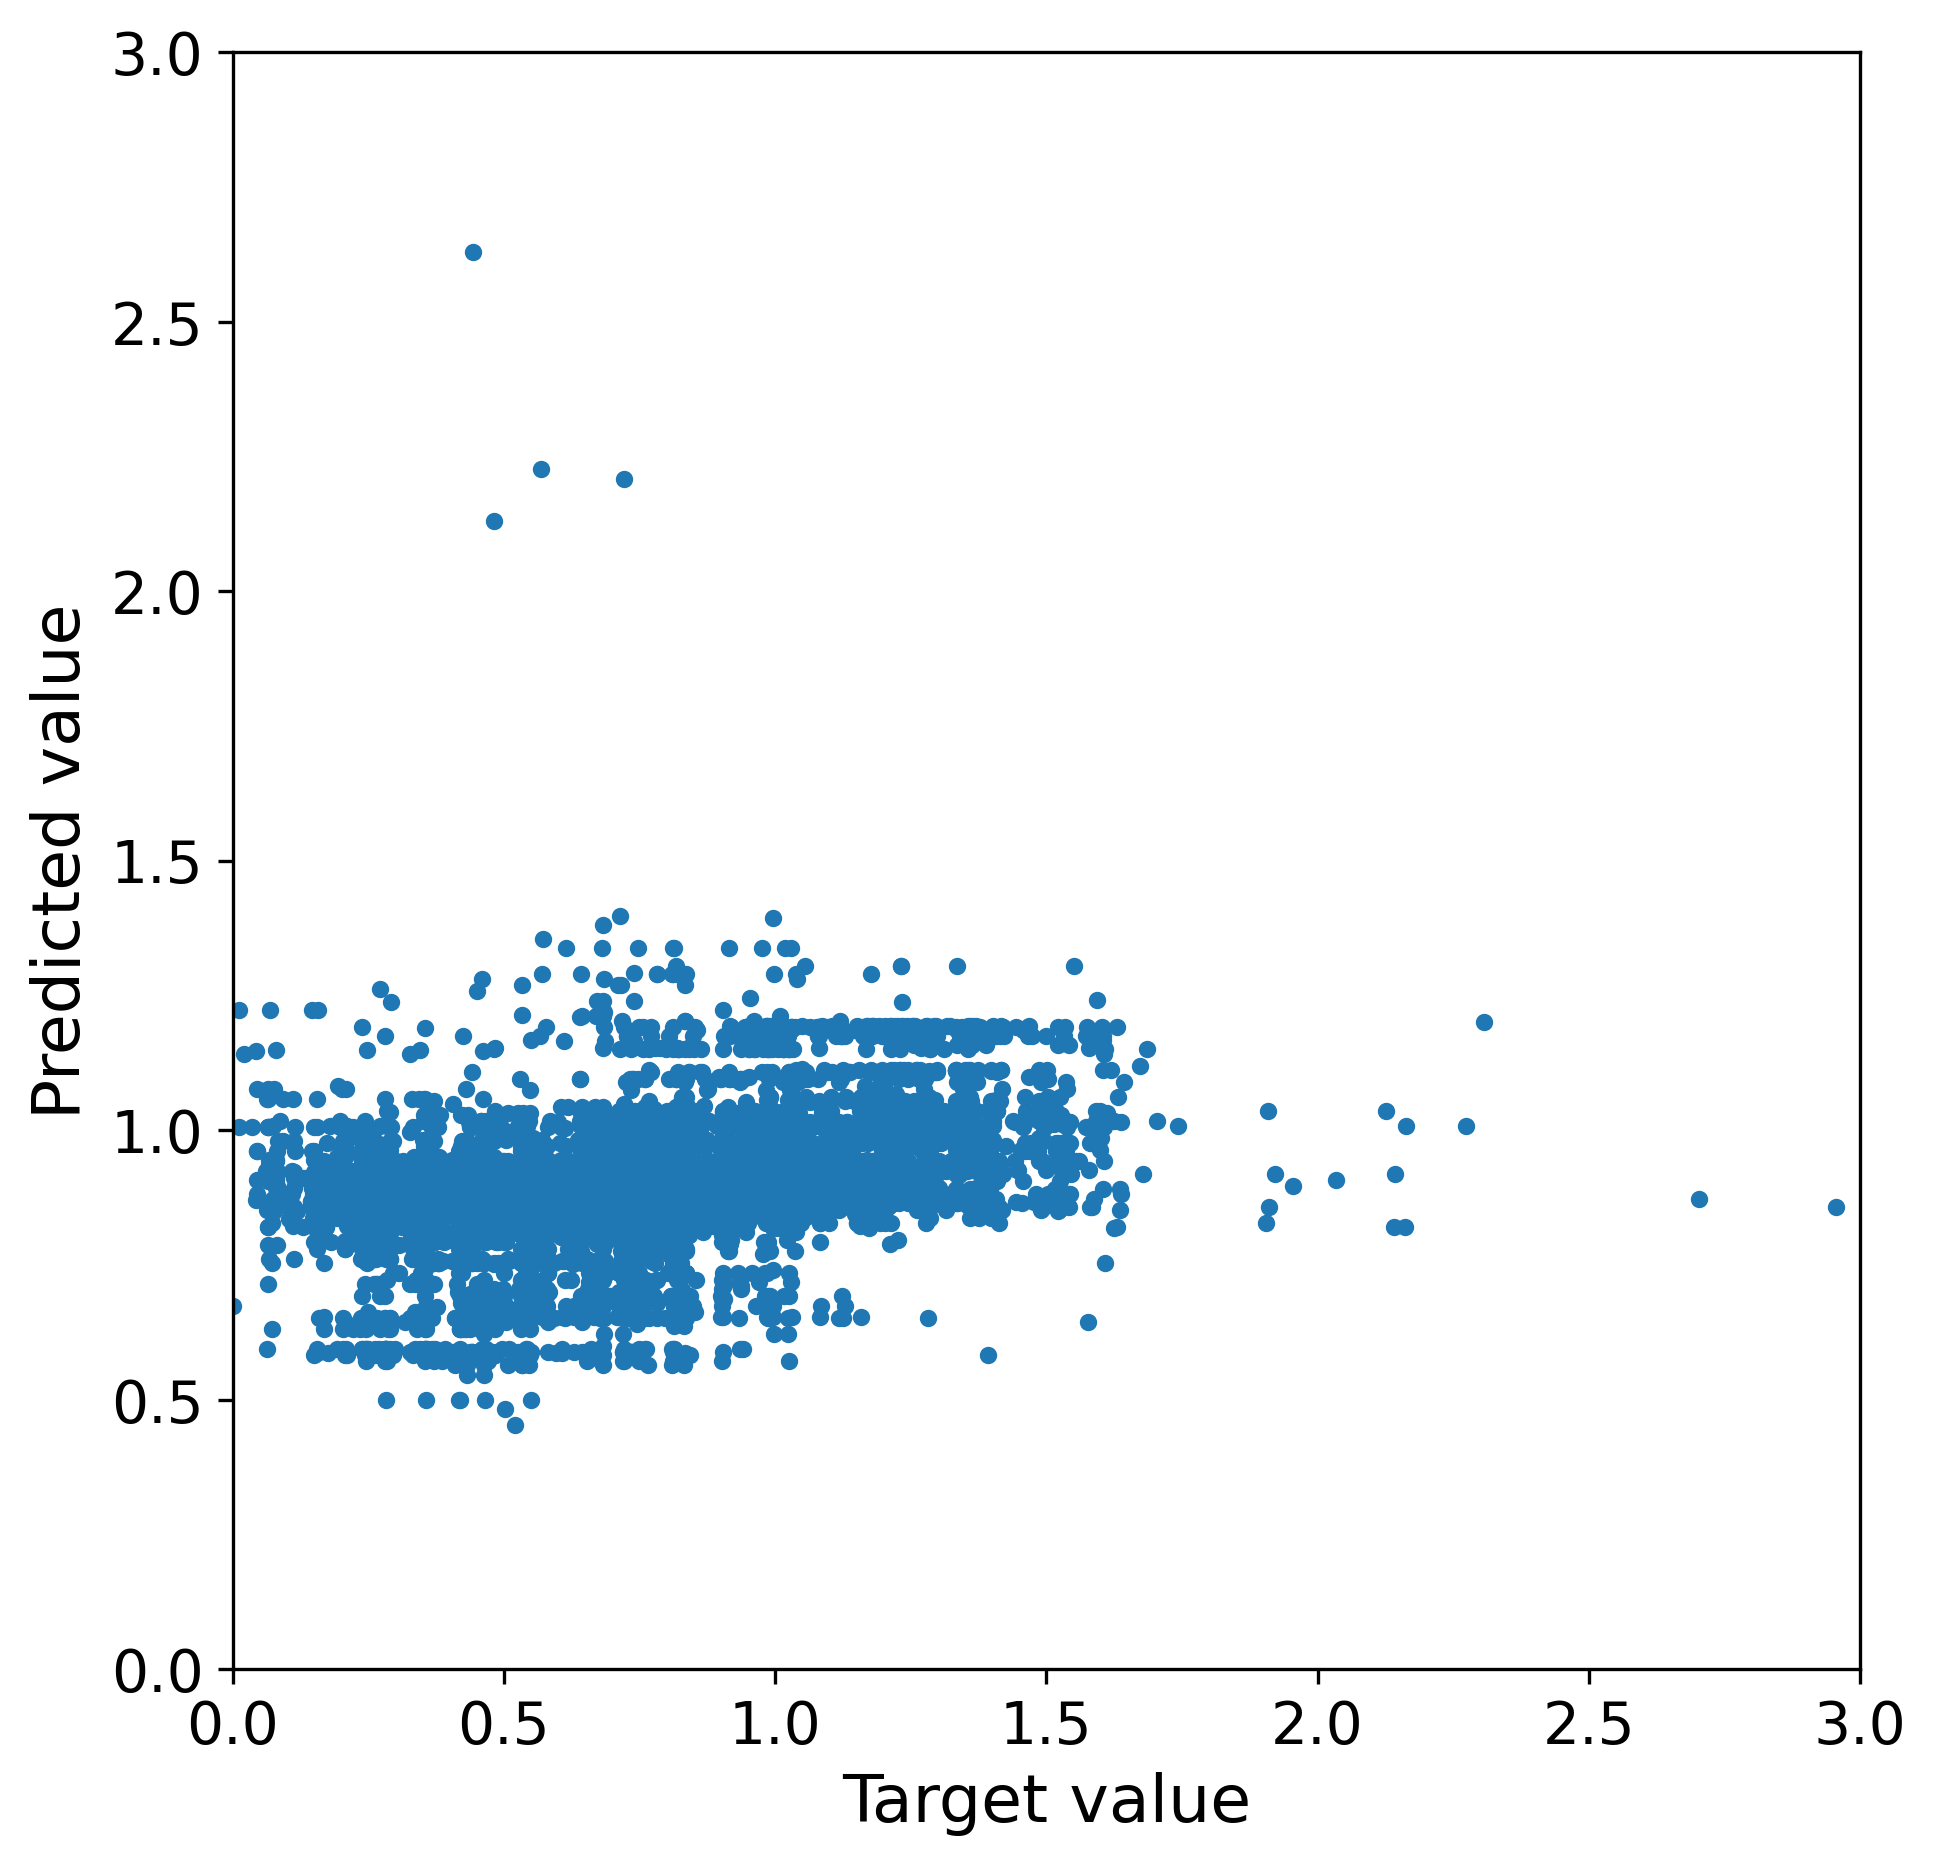

In [10]:
plt.figure(figsize=(7,7))
plt.scatter(sel_target,ypred, s =10)
plt.ylim(0,3)
plt.ylabel("Predicted value")
plt.xlim(0,3)
plt.xlabel("Target value")

### Questions: 
- What's the base estimator being boosted here? What is its max depth?
- How many estimators are being used for the boosting?
- Does the boosting seem to be working? Compare this result scatter plot to your single tree and Random Forest results from Studio 8. 

To see if the boosting is working, we can study the performance as we increase the number of estimators. If our model is "boost-worthy" the results will improve with more estimators. sk-learn's $\texttt{staged\_predict}$ is a useful tool for this: it returns an array of ensemble predictions after each iteration of boosting. To use it, we need to set up a test-train split and use the $\texttt{fit}$ method, since we want to monitor how the test accuracy changes at each iteration. 

In [11]:
X_train, X_test, y_train, y_test = \
        train_test_split(sel_features,sel_target.values.ravel(), test_size=.3, random_state=42)

We begin with a very weak learner: 

In [13]:
model= AdaBoostRegressor(DecisionTreeRegressor(max_depth=3),
                  n_estimators=30)

In [14]:
model.fit(X_train, y_train)

,estimator,DecisionTreeR...r(max_depth=3)
,n_estimators,30
,learning_rate,1.0
,loss,'linear'
,random_state,None
,criterion,'squared_error'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0


We can plot the $R^2$ score between true and predicted values as a function of the number of stages/iterations.

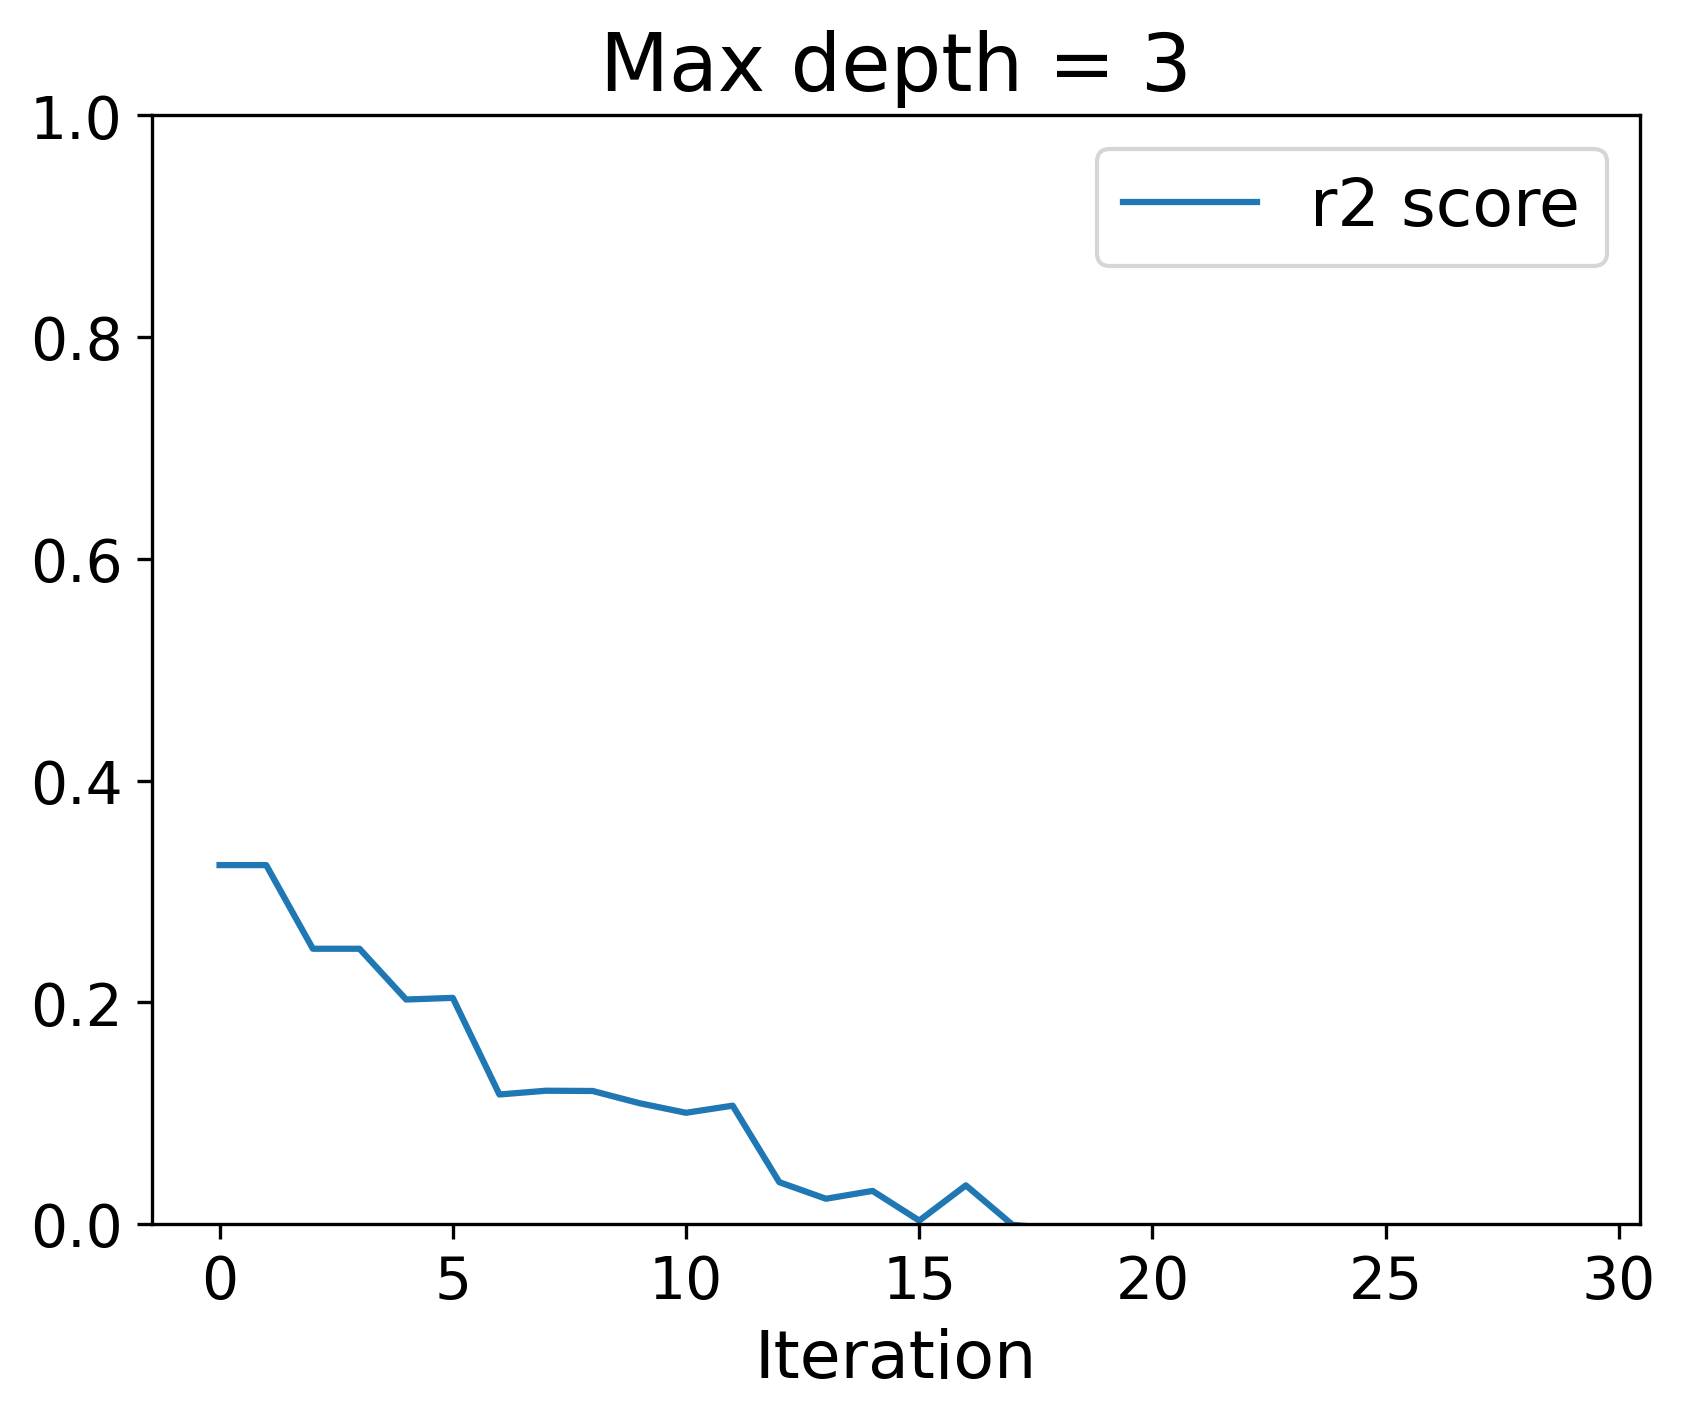

In [16]:
n_estimators = 30

plt.plot(range(n_estimators), [metrics.r2_score(y_test,list(model.staged_predict(X_test))[i]) for i in range(n_estimators)], label = 'r2 score')

plt.xlabel('Iteration')

plt.ylim(0,1.0)

plt.title('Max depth = 3')
plt.legend();

### We can now try again with a stronger base learner (max_depth = 6).

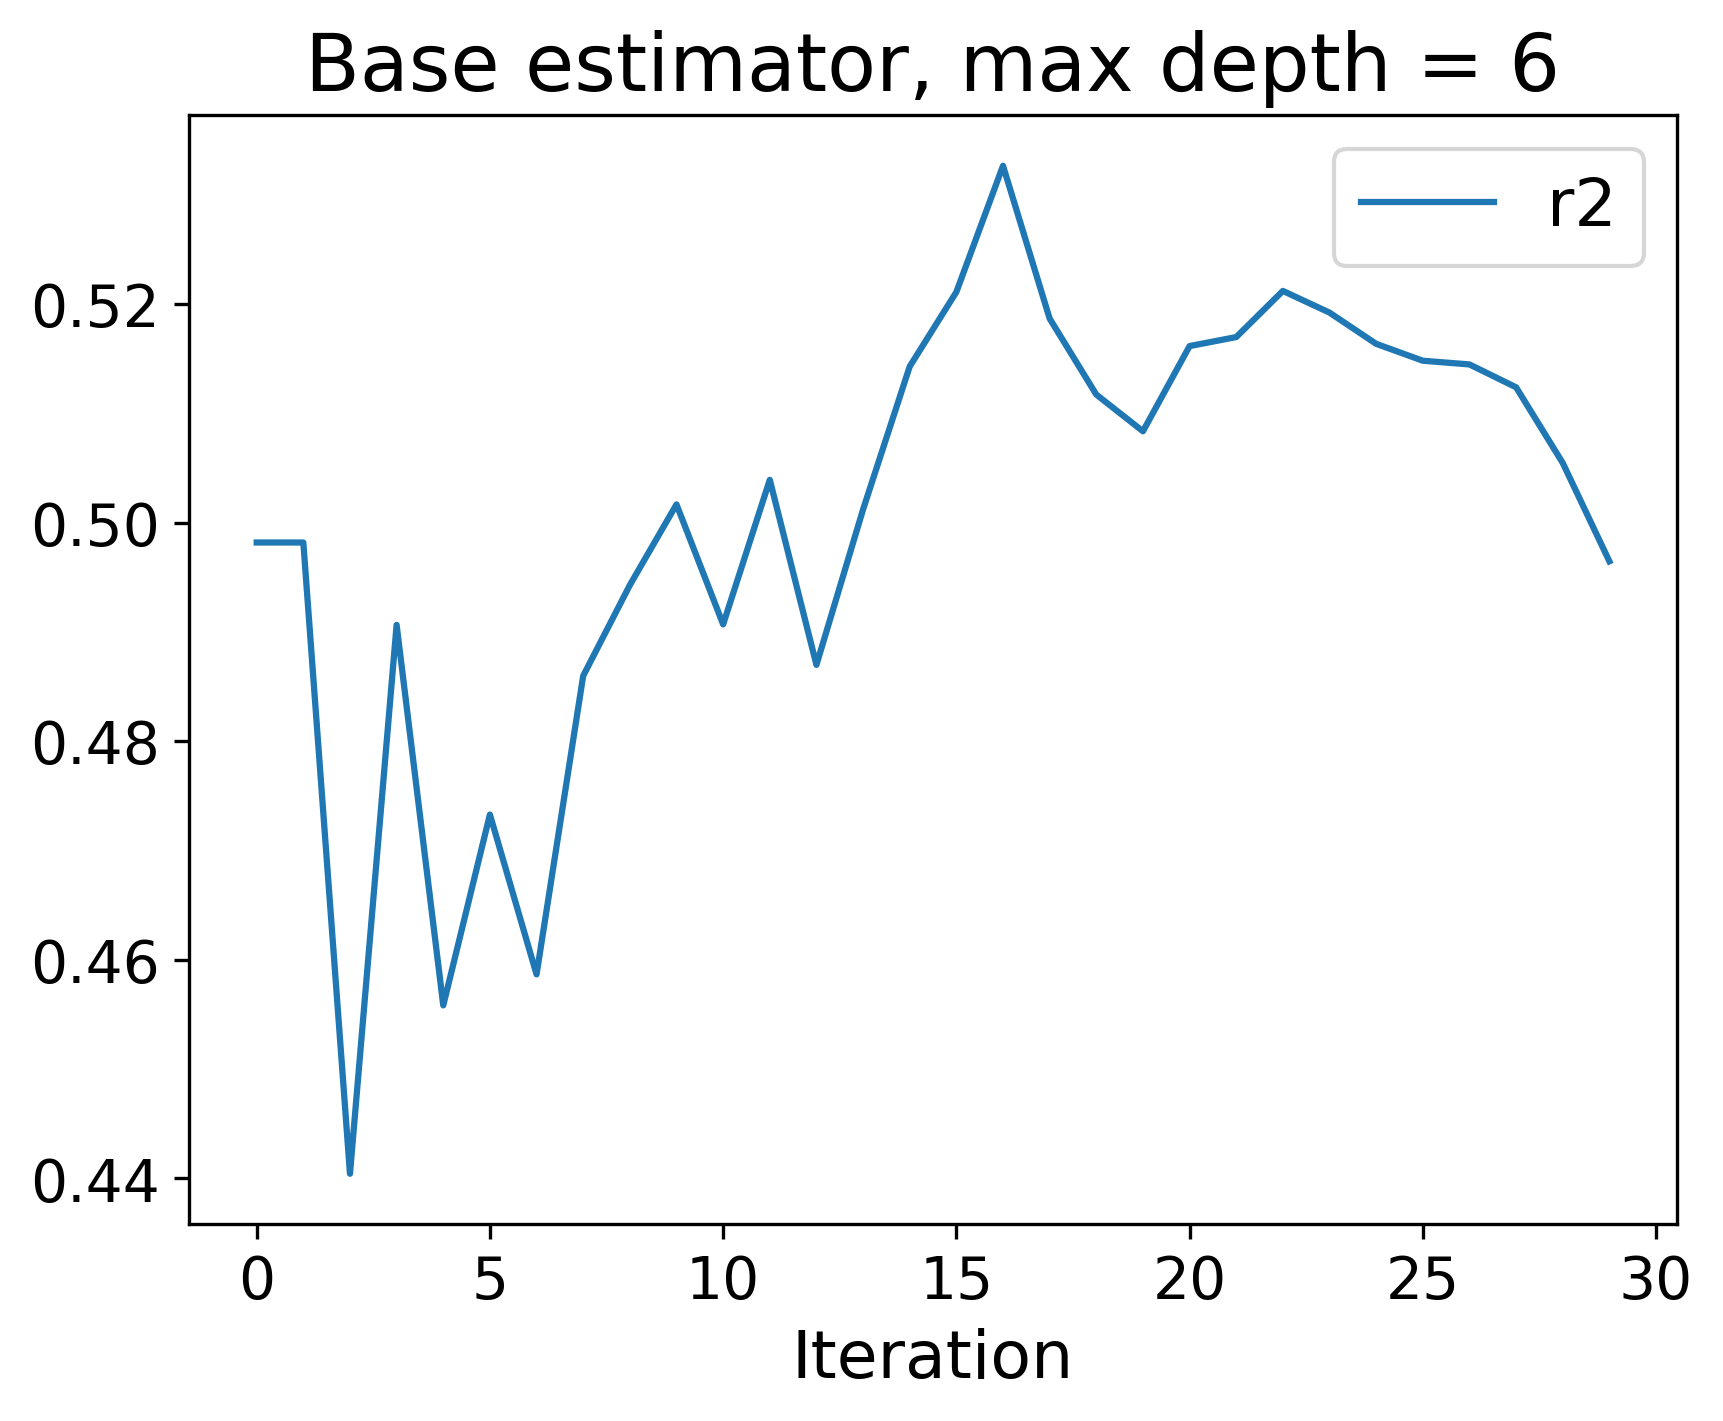

In [18]:
n_estimators = 30

model= AdaBoostRegressor(DecisionTreeRegressor(max_depth=6),
                  n_estimators=n_estimators)

X_train, X_test, y_train, y_test = \
        train_test_split(sel_features,sel_target.values.ravel(), test_size=.3, random_state=42)

model.fit(X_train, y_train)

plt.plot(range(n_estimators), [metrics.r2_score(y_test,list(model.staged_predict(X_test))[i]) for i in range(n_estimators)], label = 'r2')

plt.xlabel('Iteration')

plt.title('Base estimator, max depth = 6')

plt.legend();

### And do the same with an even stronger base learner (max_depth = 10).

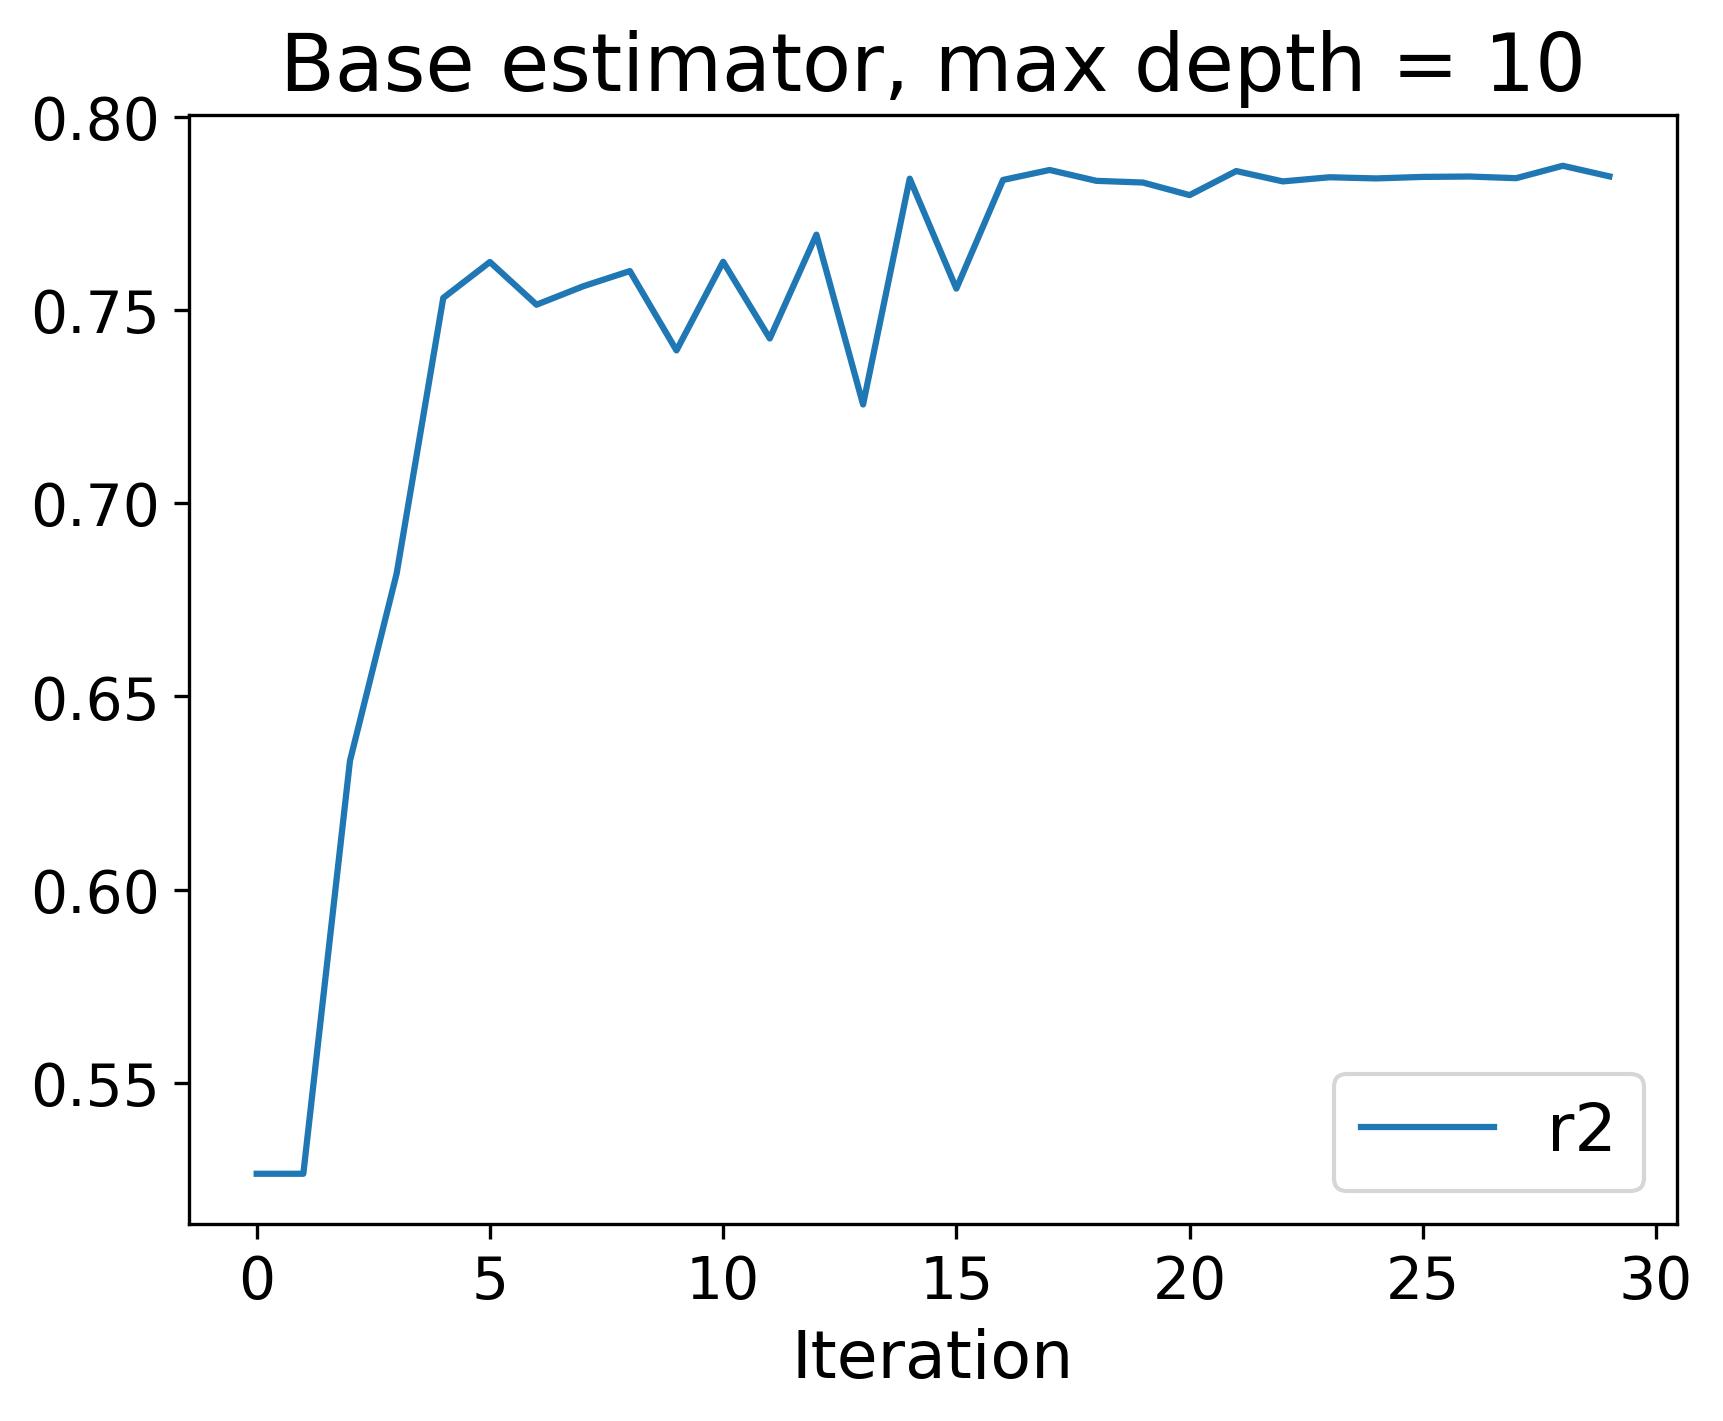

In [19]:
n_estimators = 30

model= AdaBoostRegressor(DecisionTreeRegressor(max_depth=10),
                  n_estimators=30)

X_train, X_test, y_train, y_test = \
        train_test_split(sel_features,sel_target.values.ravel(), test_size=.3, random_state=42)

model.fit(X_train, y_train)

plt.plot(range(n_estimators), [metrics.r2_score(y_test,list(model.staged_predict(X_test))[i]) for i in range(n_estimators)], label = 'r2')

plt.xlabel('Iteration')

plt.title('Base estimator, max depth = 10')

plt.legend();

### Let's combine all of them in one figure.

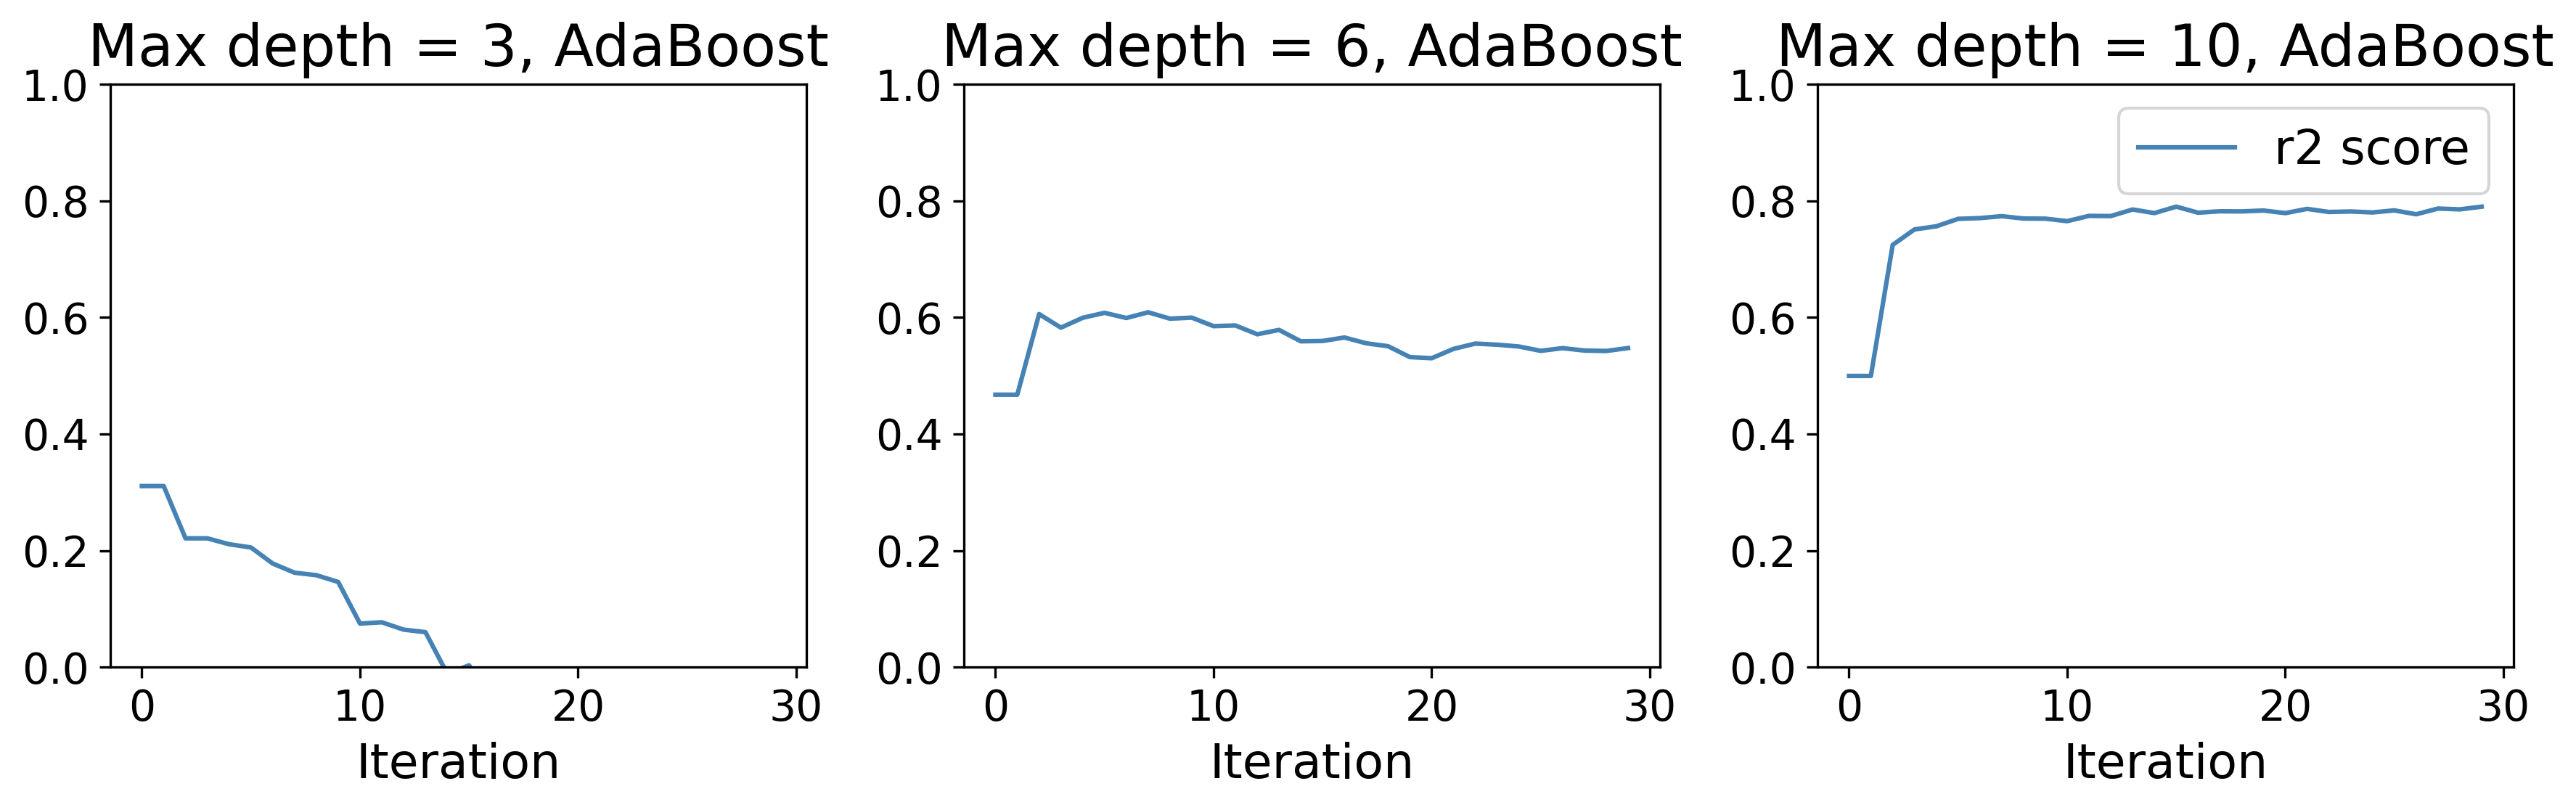

In [21]:
plt.figure(figsize=(12,4))

n_estimators = 30

for i, md in enumerate([3,6,10]):
    
    model = AdaBoostRegressor(DecisionTreeRegressor(max_depth=md),
                  n_estimators=n_estimators)

    model.fit(X_train,y_train)
    
    plt.subplot(1,3,i+1)

    plt.plot(range(n_estimators), [metrics.r2_score(y_test,list(model.staged_predict(X_test))[i]) for i in range(n_estimators)], label = 'r2 score', c = 'steelblue')

    plt.xlabel('Iteration')

    plt.ylim(0,1.0)

    plt.title('Max depth = '+str(md)+', AdaBoost')
    
    if i == 2:
        plt.legend();
    
    plt.tight_layout()

#plt.savefig('AdaB_performance.png')

### Question:
What is the "boost-worthy" threshold for Adaptive Boosting in this problem? (i.e. what base learners does boosting work for, from what you observe above?)

### We sort-of have an answer from the third panel of the figure above, but we could also ask whether we should keep boosting (i.e. if adding more stages is beneficial.).

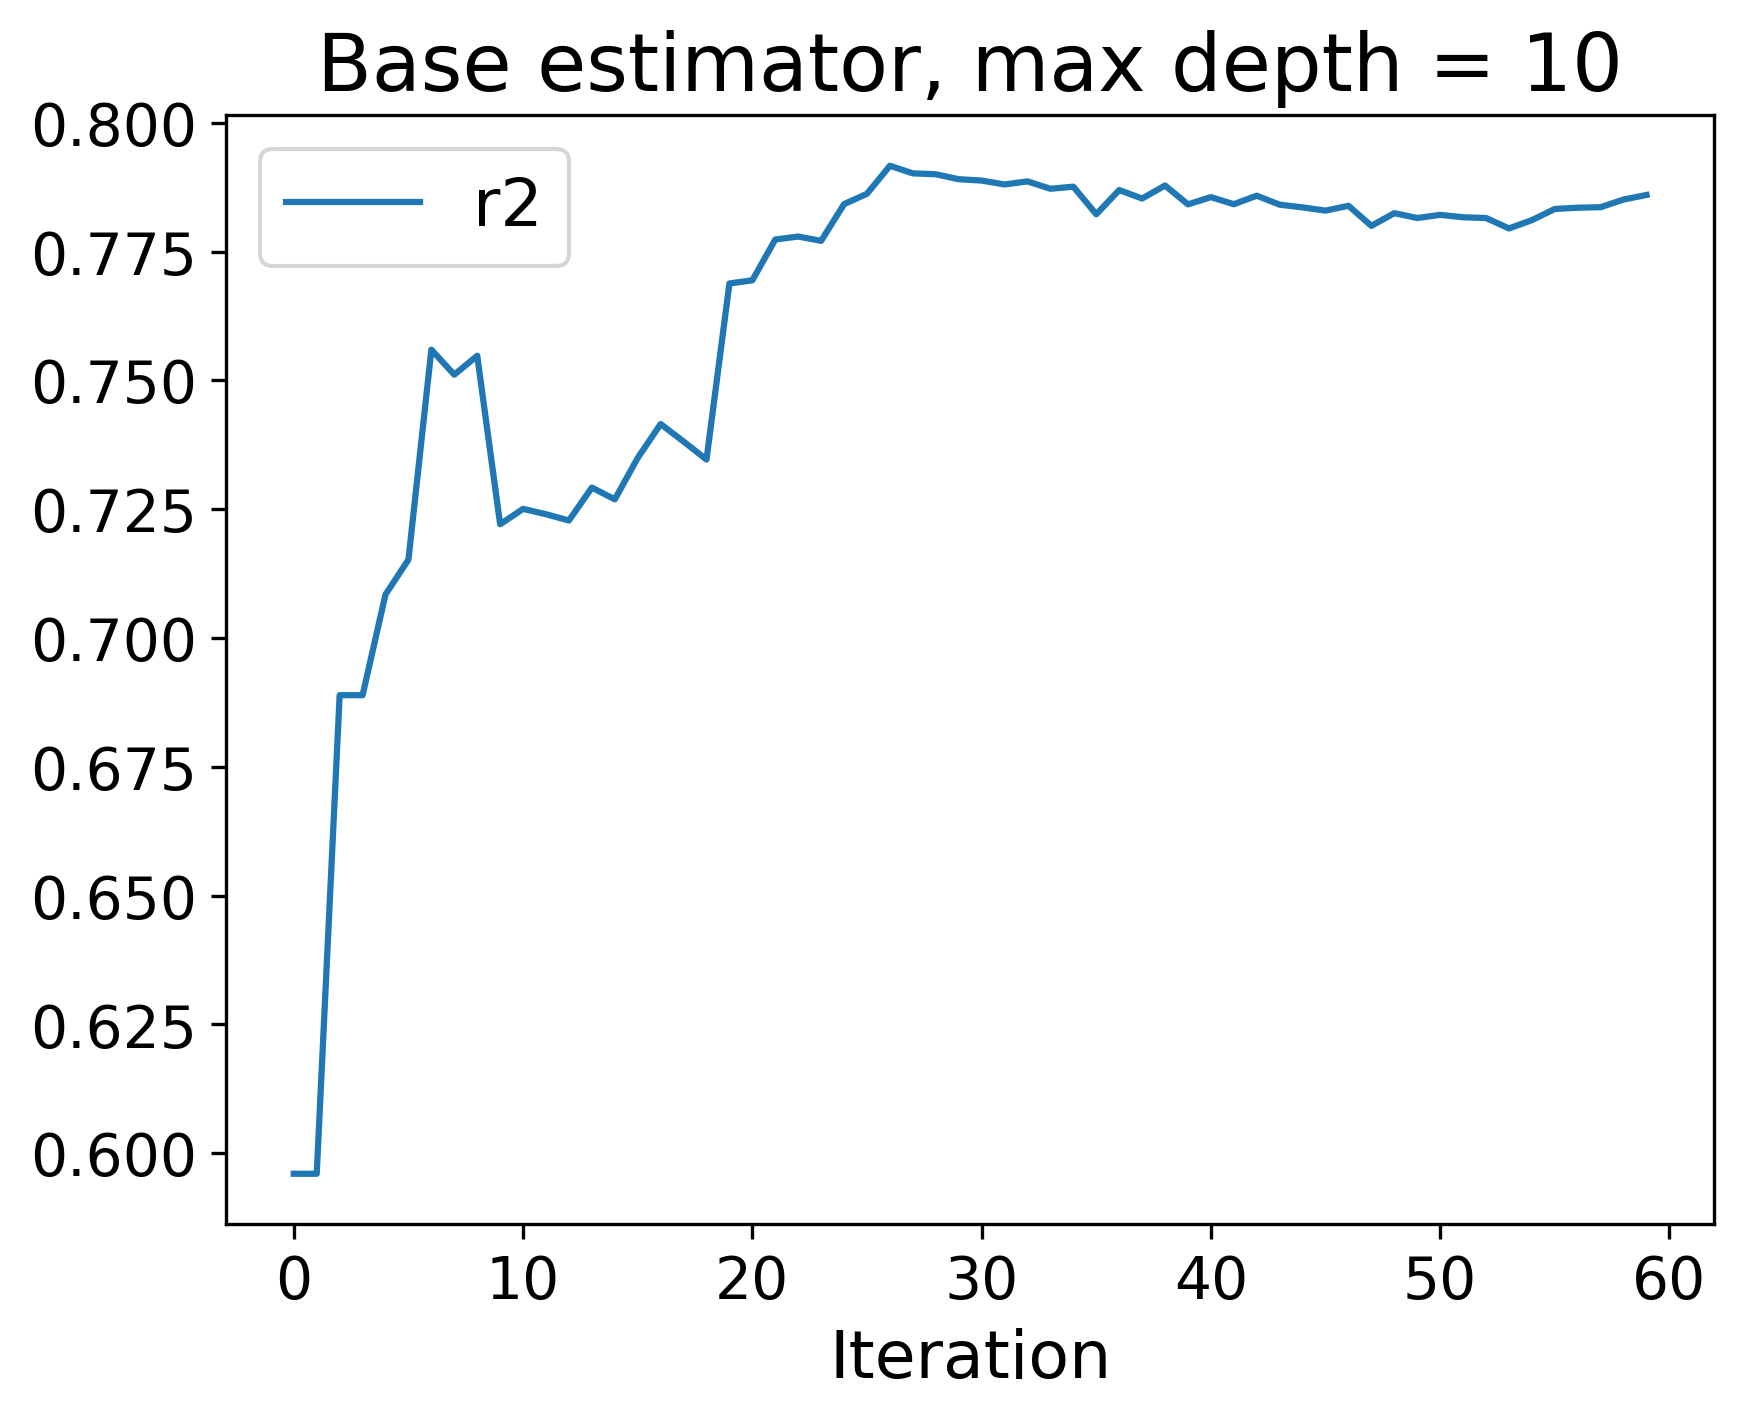

In [22]:
#Shall we keep boosting? (max_depth = 10)

n_estimators = 60

model= AdaBoostRegressor(DecisionTreeRegressor(max_depth=10),
                  n_estimators=n_estimators)

X_train, X_test, y_train, y_test = \
        train_test_split(sel_features,sel_target.values.ravel(), test_size=.3, random_state=42)

model.fit(X_train, y_train)

plt.plot(range(n_estimators), [metrics.r2_score(y_test,list(model.staged_predict(X_test))[i]) for i in range(n_estimators)], label = 'r2')

plt.xlabel('Iteration')

plt.title('Base estimator, max depth = 10')

plt.legend();


### Questions: 
- Does adaptive boosting work with any base estimator? Or can estimators be too weak to work?
- Does adding more boosting stages always improve the results?




### Would this be true also for Gradient Boosted Trees algorithms?

There is only one way to find out!

In [23]:
from sklearn.ensemble import GradientBoostingRegressor

The parameters depend on the particular implementation.

In the sklearn formulation, the parameters of each tree are essentially the same we have for Random Forests; additionally we have the "learning_rate" parameter, which dictates how much each tree contribute to the final estimator, and the "subsample" parameters, which allows one to use a < 1.0 fraction of samples.


Let's test different tree depths with Gradient Boosting and see if there's a "boost-worthy" threshold. 

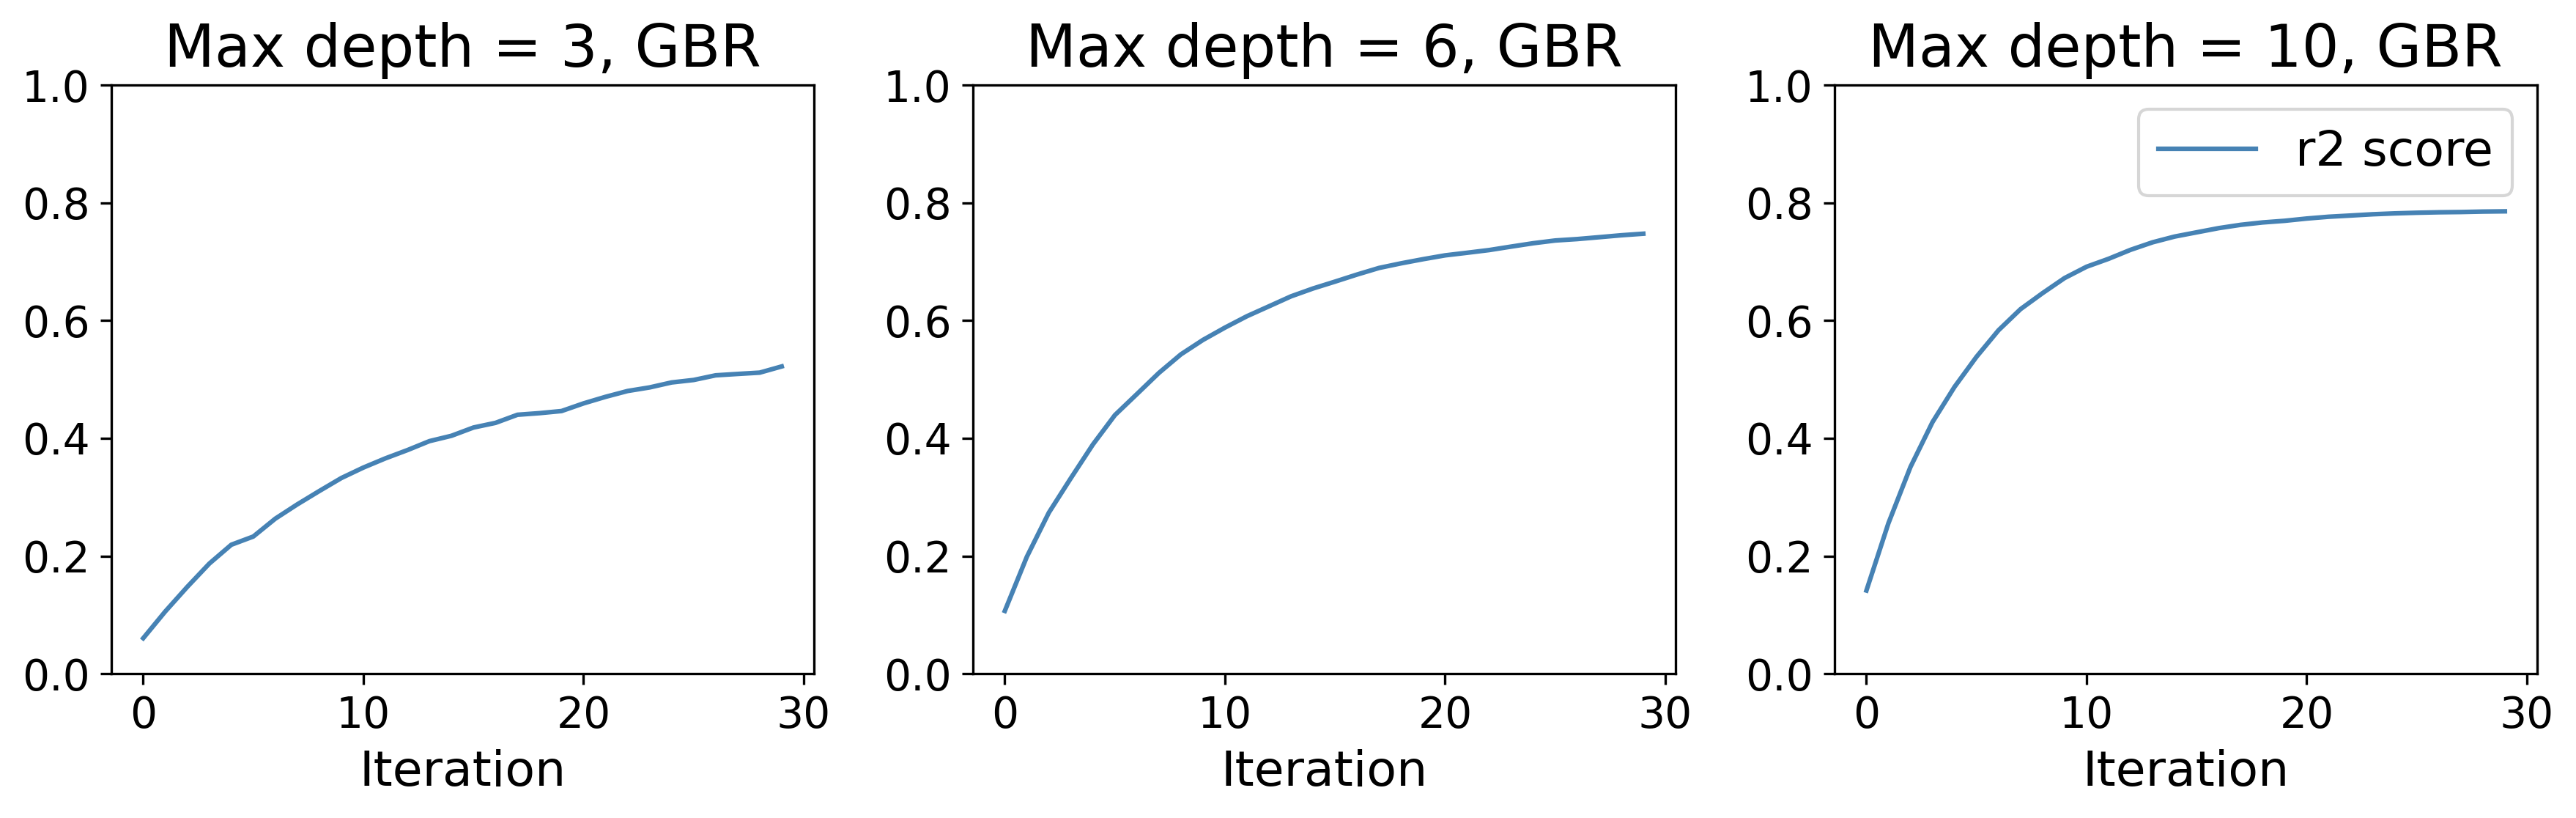

In [24]:
plt.figure(figsize=(12,4))

n_estimators = 30

for i, md in enumerate([3,6,10]):
    
    model = GradientBoostingRegressor(max_depth=md,
                  n_estimators=n_estimators)

    model.fit(X_train,y_train)
    
    plt.subplot(1,3,i+1)

    plt.plot(range(n_estimators), [metrics.r2_score(y_test,list(model.staged_predict(X_test))[i]) for i in range(n_estimators)], label = 'r2 score', c = 'steelblue')

    plt.xlabel('Iteration')

    plt.ylim(0,1.0)

    plt.title('Max depth = '+str(md)+', GBR')
    
    if i == 2:
        plt.legend();
    
    plt.tight_layout()

#plt.savefig('GBR_performance.pdf')

### Questions:
- Does gradient boosting work with any base estimator? Or can estimators be too weak to work?
- Does adding more boosting stages always improve the results?

### Hyperparameter Optimization 
Now that we know what range of tree depth hyperparameters is interesting in each case, let's run hyperparameter optimization, examine the best-performing models, and compare the results. We'll also compare to the RandomForests approach from last studio. 

In [ ]:
# This took 1m and 3 sec on my laptop
parameters = {'estimator__max_depth':[6,10,None], 'loss':['linear','square'], 'n_estimators':[20,50,100], 'learning_rate': [0.3,0.5,1.0]}
nmodels = np.prod([len(el) for el in parameters.values()])
model = GridSearchCV(AdaBoostRegressor(DecisionTreeRegressor()), parameters, \
                     cv = KFold(n_splits=5, shuffle=True, random_state = 5), \
                     verbose = 2, n_jobs = 4, return_train_score=True)
model.fit(sel_features,sel_target.values.ravel())

print('Best params, best score:', "{:.4f}".format(model.best_score_), \
      model.best_params_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END estimator__max_depth=6, learning_rate=0.3, loss=linear, n_estimators=20; total time=   0.2s
[CV] END estimator__max_depth=6, learning_rate=0.3, loss=linear, n_estimators=20; total time=   0.2s
[CV] END estimator__max_depth=6, learning_rate=0.3, loss=linear, n_estimators=20; total time=   0.2s
[CV] END estimator__max_depth=6, learning_rate=0.3, loss=linear, n_estimators=20; total time=   0.2s
[CV] END estimator__max_depth=6, learning_rate=0.3, loss=linear, n_estimators=20; total time=   0.2s
[CV] END estimator__max_depth=6, learning_rate=0.3, loss=linear, n_estimators=50; total time=   0.5s
[CV] END estimator__max_depth=6, learning_rate=0.3, loss=linear, n_estimators=50; total time=   0.5s
[CV] END estimator__max_depth=6, learning_rate=0.3, loss=linear, n_estimators=50; total time=   0.5s
[CV] END estimator__max_depth=6, learning_rate=0.3, loss=linear, n_estimators=50; total time=   0.5s
[CV] END estimator__max_depth

Let's look at the winning model scores and parameters. We also want to look at the standard deviation of test scores, since we want to know what differences are statistically signficant when we compare models.

In [ ]:
scores = pd.DataFrame(model.cv_results_)
scoresCV = scores[['params','mean_test_score','std_test_score','mean_train_score']].sort_values(by = 'mean_test_score', \
                                                    ascending = False)
scoresCV.head()

,params,mean_test_score,std_test_score,mean_train_score
43,"{'estimator__max_depth': None, 'learning_rate': 0.5, 'loss': 'linear', 'n_estimators': 50}",0.755931,0.031014,0.999982
45,"{'estimator__max_depth': None, 'learning_rate': 0.5, 'loss': 'square', 'n_estimators': 20}",0.747949,0.031505,0.999379
50,"{'estimator__max_depth': None, 'learning_rate': 1.0, 'loss': 'linear', 'n_estimators': 100}",0.745817,0.057528,0.999742
53,"{'estimator__max_depth': None, 'learning_rate': 1.0, 'loss': 'square', 'n_estimators': 100}",0.745468,0.031010,0.981071
51,"{'estimator__max_depth': None, 'learning_rate': 1.0, 'loss': 'square', 'n_estimators': 20}",0.741654,0.032980,0.989081


We can see that the standard deviation is 0.03 - giving us a hint of what's significant - and that a few different models have similar scores. If you change the random seed in the cross validation, the scores will change by a similar amount, and the best model may change as well.

Additionally, the resulting scores will not be exactly reproducible because there is another random component in the adaptive learning set (this means that if you run the cross_validate function using the best model from above, you might get a different average score!)

We can also look at the worst-performing models, to see which hyperparameters are having a strong effect:


In [30]:
scoresCV.tail()

,params,mean_test_score,std_test_score,mean_train_score
13,"{'estimator__max_depth': 6, 'learning_rate': 1.0, 'loss': 'linear', 'n_estimators': 50}",0.484219,0.033715,0.640761
14,"{'estimator__max_depth': 6, 'learning_rate': 1.0, 'loss': 'linear', 'n_estimators': 100}",0.477056,0.036351,0.642893
9,"{'estimator__max_depth': 6, 'learning_rate': 0.5, 'loss': 'square', 'n_estimators': 20}",0.475959,0.032908,0.611898
15,"{'estimator__max_depth': 6, 'learning_rate': 1.0, 'loss': 'square', 'n_estimators': 20}",0.470737,0.043487,0.621867
3,"{'estimator__max_depth': 6, 'learning_rate': 0.3, 'loss': 'square', 'n_estimators': 20}",0.467987,0.057273,0.619244


### Questions:
- Give a brief description of the hyperparameters being varied and the values being tested for each. 
- What hyperparameter(s) have a strong effect on the adaptive boosting performance?

#### Let's pick the best model and check the scores. We should do nested cross validation to get the generalization errors right - but if we are just comparing models, this is ok.

In [31]:
bm = model.best_estimator_

Let's generate predicted values.

In [32]:
y_pred_bm = cross_val_predict(bm, sel_features, sel_target.values.ravel(), cv = KFold(n_splits=5, shuffle = True, random_state=10))

Calculate outlier fraction and NMAD:

In [33]:
print(np.round(len(np.where(np.abs(sel_target.values.ravel()-y_pred_bm)>0.15*(1+sel_target.values.ravel()))[0])/len(sel_target.values.ravel()),3))

print(np.round(1.48*np.median(np.abs(sel_target.values.ravel()-y_pred_bm)/(1 + sel_target.values.ravel())),3))

0.045
0.032


These are actually better than what we obtained for the Random Forests model! But is the difference statistically significant? One way to explore this is by generating several sets of predictions, and calculating their standard deviation.

In [34]:
seeds = np.random.choice(100,8, replace = False) #pick 8 different seeds

olf = np.zeros(8)
NMAD = np.zeros(8)

for i in range(8): #A bit rough, but it gives a sense of what happens by varying the random seeds!
    print('Iteration', i) #this is just to see the progress.
    ypred = cross_val_predict(bm, sel_features, sel_target.values.ravel(), cv = KFold(n_splits=5, shuffle=True, random_state=seeds[i]))
    olf[i] = len(np.where(np.abs(sel_target.values.ravel()-ypred)>0.15*(1+sel_target.values.ravel()))[0])/len(sel_target.values.ravel())
    NMAD[i] = 1.48*np.median(np.abs(sel_target.values.ravel()-ypred)/(1 + sel_target.values.ravel()))

print('OLF avg/std:, {0:.5f}, {1:0.5f}'.format(olf.mean(), olf.std()))
print('NMAD avg/std:, {0:.5f}, {1:0.5f}'.format(NMAD.mean(), NMAD.std()))

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
OLF avg/std:, 0.04574, 0.00125
NMAD avg/std:, 0.03264, 0.00029


Taking the same approach in Studio 8, we found that using Random Forests, our results were:

OLF avg/std:, 0.05708, 0.00081

NMAD avg/std:, 0.03687, 0.00041


### Question: 
Which method would you recommend for this problem: Adaptive Boosting or Random Forest? Why?

### The next step is to compare Adaptive Boosting with different Gradient Boosted Trees algorithms. 

We begin by using sklearn's GBM, then we move on to the lighter version, HistGBM, and finally we consider one of the most popular GBT-based algorithm, XGBoost.

We also take a look at the possibility of using a Randomized Search instead of a Grid Search in order to speed up our optimization process.

### We can run the optimization process for this algorithm on a similar grid to the one used for AdaBoost.

In [ ]:
# %%time
# This took about 2.5 minutes on my machine

parameters = {'max_depth':[6,10,None], 'loss':['squared_error','absolute_error'], 
              'n_estimators':[20,50,100], 'learning_rate': [0.1,0.3,0.5]}
nmodels = np.prod([len(el) for el in parameters.values()])
model = GridSearchCV(GradientBoostingRegressor(), parameters, 
                     cv = KFold(n_splits=5, shuffle=True, random_state = 5), \
                     verbose = 2, n_jobs = 4, return_train_score=True)
model.fit(sel_features,sel_target.values.ravel())

print('Best params, best score:', "{:.4f}".format(model.best_score_), \
      model.best_params_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END learning_rate=0.1, loss=squared_error, max_depth=6, n_estimators=20; total time=   0.3s
[CV] END learning_rate=0.1, loss=squared_error, max_depth=6, n_estimators=20; total time=   0.3s
[CV] END learning_rate=0.1, loss=squared_error, max_depth=6, n_estimators=20; total time=   0.3s
[CV] END learning_rate=0.1, loss=squared_error, max_depth=6, n_estimators=20; total time=   0.3s
[CV] END learning_rate=0.1, loss=squared_error, max_depth=6, n_estimators=20; total time=   0.3s
[CV] END learning_rate=0.1, loss=squared_error, max_depth=6, n_estimators=50; total time=   0.7s
[CV] END learning_rate=0.1, loss=squared_error, max_depth=6, n_estimators=50; total time=   0.7s
[CV] END learning_rate=0.1, loss=squared_error, max_depth=6, n_estimators=50; total time=   0.7s
[CV] END learning_rate=0.1, loss=squared_error, max_depth=6, n_estimators=50; total time=   0.7s
[CV] END learning_rate=0.1, loss=squared_error, max_depth=6, n_es

These are comparable to what we obtained with AdaBoost (slightly lower, typically). We can check what happens to the outlier fraction and NMAD.

In [37]:
bm = model.best_estimator_

In [38]:
y_pred_bm = cross_val_predict(bm, sel_features, sel_target.values.ravel(), cv = KFold(n_splits=5, shuffle = True, random_state=10))

In [39]:
print(np.round(len(np.where(np.abs(sel_target.values.ravel()-y_pred_bm)>0.15*(1+sel_target.values.ravel()))[0])/len(sel_target.values.ravel()),3))

print(np.round(1.48*np.median(np.abs(sel_target.values.ravel()-y_pred_bm)/(1 + sel_target.values.ravel())),3))

0.056
0.038


Overall, the performance of the two algorithms is similar, but one important difference is *timing*. To explore exactly the same parameter space, GBR took ~ 2 times longer than AdaBoost. Additionally, gradient boosted methods typically require more estimators, and we should explore more regularization parameters (e.g. subsampling) as well. In a nutshell, it would be great to speed up things.

### How can we make things faster?

We can improve on the time constraints in two ways: by switching to the histogram-based version of Gradient Boosting Regressor, and by using a Random Search instead of a Grid Search.

HistGradientBoostingRegressor (inspired by [LightGBM](https://lightgbm.readthedocs.io/en/latest/)) works by binning the features into integer-valued bins (the default value is 256, but this parameter can be adjusted; note however that 256 is the maximum!), which greatly reduces the number of splitting points to consider, and results in a vast reduction of computation time, especially for large data sets.

In [40]:
from sklearn.ensemble import HistGradientBoostingRegressor

In [ ]:
# %%time
# This took ~ 53s on my laptop

parameters = {'max_depth':[6,10,None], 'loss':['squared_error','absolute_error'], 
              'max_iter':[20,50,100], 'learning_rate': [0.1,0.3,0.5]}
nmodels = np.prod([len(el) for el in parameters.values()])
model = GridSearchCV(HistGradientBoostingRegressor(), parameters, 
                     cv = KFold(n_splits=5, shuffle=True, random_state = 5), \
                     verbose = 2, n_jobs = 4, return_train_score=True)
model.fit(sel_features,sel_target.values.ravel())

print('Best params, best score:', "{:.4f}".format(model.best_score_), \
      model.best_params_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END learning_rate=0.1, loss=squared_error, max_depth=6, max_iter=20; total time=   0.3s
[CV] END learning_rate=0.1, loss=squared_error, max_depth=6, max_iter=20; total time=   0.3s
[CV] END learning_rate=0.1, loss=squared_error, max_depth=6, max_iter=20; total time=   0.3s
[CV] END learning_rate=0.1, loss=squared_error, max_depth=6, max_iter=20; total time=   0.3s
[CV] END learning_rate=0.1, loss=squared_error, max_depth=6, max_iter=20; total time=   0.3s
[CV] END learning_rate=0.1, loss=squared_error, max_depth=6, max_iter=50; total time=   0.6s
[CV] END learning_rate=0.1, loss=squared_error, max_depth=6, max_iter=50; total time=   0.6s
[CV] END learning_rate=0.1, loss=squared_error, max_depth=6, max_iter=50; total time=   0.6s
[CV] END learning_rate=0.1, loss=squared_error, max_depth=6, max_iter=50; total time=   0.4s
[CV] END learning_rate=0.1, loss=squared_error, max_depth=6, max_iter=50; total time=   0.4s
[CV] END

In [42]:
scores = pd.DataFrame(model.cv_results_)
scoresCV = scores[['params','mean_test_score','std_test_score','mean_train_score']].sort_values(by = 'mean_test_score', \
                                                    ascending = False)
scoresCV.head()

,params,mean_test_score,std_test_score,mean_train_score
26,"{'learning_rate': 0.3, 'loss': 'squared_error', 'max_depth': None, 'max_iter': 100}",0.721386,0.036734,0.934003
20,"{'learning_rate': 0.3, 'loss': 'squared_error', 'max_depth': 6, 'max_iter': 100}",0.719629,0.031527,0.889775
8,"{'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': None, 'max_iter': 100}",0.718633,0.039798,0.858452
23,"{'learning_rate': 0.3, 'loss': 'squared_error', 'max_depth': 10, 'max_iter': 100}",0.717640,0.035547,0.923584
5,"{'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 10, 'max_iter': 100}",0.715118,0.039476,0.843148


Even for this relatively small data set, this is much faster (about 3x faster than GradientBoostingRegressor), giving us a chance to explore a wider parameter space (e.g. more trees, more options for learning rate). The trade-off is that we obtain a slight decrease in performance, compared with GBR. However, the standard deviation of test scores over the 5 CV folds suggests that this difference is not statistically significant. The speed-up from HistGBR is particularly large for large data sets (10,000 instances or more). 

Let's explore a larger set of models. Even with HistGBR, this is pretty slow, so I'll turn down the CV to 3-fold to speed things up.

In [ ]:
#%%time
# This took 4 min 37 secs

parameters = {'max_depth':[6,10,None], 'loss':['squared_error','absolute_error'], 
              'max_iter':[100,200,500], 'learning_rate': [0.05, 0.1,0.3,0.5], 
              'early_stopping':[True, False]}
nmodels = np.prod([len(el) for el in parameters.values()])
model = GridSearchCV(HistGradientBoostingRegressor(), parameters, cv = KFold(n_splits=3, shuffle=True), \
                     verbose = 2, n_jobs = 4, return_train_score=True)
model.fit(sel_features,sel_target.values.ravel())

print('Best params, best score:', "{:.4f}".format(model.best_score_), \
      model.best_params_)

Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV] END early_stopping=True, learning_rate=0.05, loss=squared_error, max_depth=6, max_iter=100; total time=   1.1s
[CV] END early_stopping=True, learning_rate=0.05, loss=squared_error, max_depth=6, max_iter=100; total time=   1.1s
[CV] END early_stopping=True, learning_rate=0.05, loss=squared_error, max_depth=6, max_iter=100; total time=   1.1s
[CV] END early_stopping=True, learning_rate=0.05, loss=squared_error, max_depth=6, max_iter=200; total time=   1.7s
[CV] END early_stopping=True, learning_rate=0.05, loss=squared_error, max_depth=6, max_iter=500; total time=   1.7s
[CV] END early_stopping=True, learning_rate=0.05, loss=squared_error, max_depth=6, max_iter=200; total time=   1.8s
[CV] END early_stopping=True, learning_rate=0.05, loss=squared_error, max_depth=6, max_iter=200; total time=   1.9s
[CV] END early_stopping=True, learning_rate=0.05, loss=squared_error, max_depth=6, max_iter=500; total time=   2.5s
[CV] END 

We'd like to explore a wider parameter space here, but let's do one more thing to speed up the search: we can explore the hyperparameter space using Random Search instead of a Grid Search. 

Random Search is usually preferable when we have a high-dimensional parameter space; its use is not particularly warranted here.

The number of iterations (the number of models that are considered) also needs to be adjusted, and depends on the dimensionality of the parameter space as well as the functional dependence of the loss function on the parameters. We will compare the timings with the cell above, where we explore 144 models, and only use 30 for the random search.


The references here explores various ways of running a parameter search.

Bergstra, J. and Bengio, Y., Random search for hyper-parameter optimization, The Journal of Machine Learning Research (2012)

Bergstra, James, et al. "Algorithms for hyper-parameter optimization." Advances in neural information processing systems 24 (2011).


In [45]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
#%%time
# 1 min 5 seconds

parameters = {'max_depth':[6,10,None], 'loss':['squared_error','absolute_error'], 
              'max_iter':[100,200,500], 'learning_rate': [0.05, 0.1,0.3,0.5], 
             'early_stopping':[True, False]}
nmodels = np.prod([len(el) for el in parameters.values()])
model = RandomizedSearchCV(HistGradientBoostingRegressor(), parameters, cv = KFold(n_splits=3, shuffle=True), \
                     verbose = 2, n_jobs = 4, return_train_score=True, n_iter=30)
model.fit(sel_features,sel_target.values.ravel())

print('Best params, best score:', "{:.4f}".format(model.best_score_), \
      model.best_params_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END early_stopping=True, learning_rate=0.5, loss=squared_error, max_depth=10, max_iter=200; total time=   0.2s
[CV] END early_stopping=True, learning_rate=0.5, loss=squared_error, max_depth=10, max_iter=200; total time=   0.4s
[CV] END early_stopping=True, learning_rate=0.5, loss=squared_error, max_depth=10, max_iter=200; total time=   0.4s
[CV] END early_stopping=True, learning_rate=0.05, loss=squared_error, max_depth=6, max_iter=200; total time=   1.9s
[CV] END early_stopping=True, learning_rate=0.05, loss=squared_error, max_depth=6, max_iter=200; total time=   1.6s
[CV] END early_stopping=True, learning_rate=0.05, loss=squared_error, max_depth=6, max_iter=200; total time=   1.9s
[CV] END early_stopping=True, learning_rate=0.3, loss=absolute_error, max_depth=6, max_iter=200; total time=   1.4s
[CV] END early_stopping=True, learning_rate=0.3, loss=absolute_error, max_depth=6, max_iter=200; total time=   1.2s
[CV] END ea

The Randomized Search was able to find a comparably good solution in about 1/5 of the time. As we mentioned, the true gains of a Randomized Search pertain to exploring high-dimensional spaces. It is also possible to use the Randomized Search to find the general area of optimal parameters, and then refine the search in that neighborhood with a finer Grid Search.

In [49]:
scores = pd.DataFrame(model.cv_results_)
scoresCV = scores[['params','mean_test_score','std_test_score','mean_train_score']].sort_values(by = 'mean_test_score', \
                                                    ascending = False)
scoresCV.head()

,params,mean_test_score,std_test_score,mean_train_score
2,"{'max_iter': 500, 'max_depth': None, 'loss': 'squared_error', 'learning_rate': 0.3, 'early_stopp...",0.714907,0.024102,0.994430
22,"{'max_iter': 500, 'max_depth': None, 'loss': 'squared_error', 'learning_rate': 0.3, 'early_stopp...",0.714073,0.037776,0.859226
16,"{'max_iter': 500, 'max_depth': 10, 'loss': 'squared_error', 'learning_rate': 0.05, 'early_stoppi...",0.713124,0.037264,0.860835
29,"{'max_iter': 500, 'max_depth': None, 'loss': 'absolute_error', 'learning_rate': 0.05, 'early_sto...",0.711447,0.048267,0.763178
10,"{'max_iter': 200, 'max_depth': None, 'loss': 'absolute_error', 'learning_rate': 0.3, 'early_stop...",0.705714,0.057288,0.772828


And the worst-performing models:

In [50]:
scoresCV.tail()

,params,mean_test_score,std_test_score,mean_train_score
21,"{'max_iter': 500, 'max_depth': 10, 'loss': 'squared_error', 'learning_rate': 0.5, 'early_stoppin...",0.685513,0.026025,0.997391
6,"{'max_iter': 100, 'max_depth': None, 'loss': 'absolute_error', 'learning_rate': 0.05, 'early_sto...",0.683211,0.043241,0.724018
23,"{'max_iter': 200, 'max_depth': 6, 'loss': 'absolute_error', 'learning_rate': 0.5, 'early_stoppin...",0.682392,0.056149,0.758611
7,"{'max_iter': 100, 'max_depth': 10, 'loss': 'absolute_error', 'learning_rate': 0.05, 'early_stopp...",0.680677,0.041667,0.722492
25,"{'max_iter': 200, 'max_depth': None, 'loss': 'squared_error', 'learning_rate': 0.5, 'early_stopp...",0.672047,0.032308,0.835743


### Question:
What hyperparameter(s) lead to better performance?

Ensemble methods also give you nice built-in ways to evaluate feature importance. You'll try that out on the homework!

### Acknowledgement statement:

### That's it for Boosting, for now! Upload your completed notebook to Gradescope to submit it.